<h1><center><font size="6">Predicting Financial Distress</font></center></h1>

<h2><center><font size="4">Dataset used:Kaggle </font></center></h2>

<a id="top"></a> <br>
## Table of Contents
1. [Introduction](#1)

1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate](#3)
    
1. [Hyperparam Tuning - Multiple Classifiers](#4)
    1. [Data Prep](#41)
        1. [Memory Footprint Reduction](#411)
        1. [Data Splitting](#412)
        1. [Upsampling CV Train fold](#413)
    1. [Tuning Prep](#42)
        1. [Instantiate Classifiers](#421)
        1. [Define Hyperparam Search Space](#422)
            1. [Random Forest](#4221)
            1. [Extra Trees](#4222)
            1. [Gradient Boosting](#4223)
            1. [LightGBM](#4224)
            1. [XGBoost](#4225)
    1. [GridSearch](#43)
    
1. [Create Ensemble - Voting Classifier](#5)
    1. [Check out individual models](#51)
    1. [Initialize Base Classifiers](#52)
    1. [Fit Voting Classifier](#53)
    1. [Test Performance](#54)
    
1. [Conclusion](#6)

1. [References](#7)

# <a id='1'>Introduction</a>  

Based on the original data, we will attempt to make the predictions more accurate by ensembling the results from several tuned models


# <a id='2'>Initialization</a>  

## <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os

import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") 
# Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'SeriousDlqin2yrs'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No Distress', 'Distress']

input_file_name = 'cs-training.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day2_cleaned_df_output_20200515.csv'

tuned_ensemble_params_name = 'day5_grid_search_ensemble_params_'

# Enter the date in which this notebook is run
export_date = '20200515'

In [3]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
import os
print(os.listdir('../intermediate data'))
# This will list all the files in this folder

['.ipynb_checkpoints', 'Archive', 'day1_cleaned_df_output_20200511.pkl', 'day2_cleaned_df_output_20200515.csv']


## <a id='3'>Load Data & Validate</a>  

In [4]:
clean_df = pd.read_csv(clean_df_file_name)
clean_df.sample(5)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
139668,0.006685,44.0,0.0,0.157145,6458.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0,0
86028,1.000000,57.0,1.0,0.594734,6000.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0
106678,0.000000,48.0,0.0,401.500000,1.0,23.0,0.0,1.0,0.0,1.0,0.0,0.0,0
22268,0.000000,37.0,0.0,0.000000,1863.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0
141686,0.150970,61.0,0.0,0.791493,5265.0,13.0,0.0,4.0,0.0,0.0,0.0,0.0,0


Lets check the head & tail to make sure there is nothing going on

In [5]:
clean_df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
0,0.000000,29.0,0.0,0.011513,4342.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.595526,55.0,0.0,0.835333,1833.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.000000,43.0,0.0,0.043437,4166.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0


In [6]:
clean_df.tail(3)
# similar logic here

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
149997,0.967086,35.0,0.0,0.469314,3600.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0
149998,0.013522,62.0,0.0,0.257847,10098.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0
149999,0.035787,33.0,0.0,0.185247,17500.0,12.0,0.0,2.0,0.0,2.0,0.0,0.0,0


No data corruption seen in either the head or the tail

## <a id='4'>Hyperparam Tuning - Multiple Classifiers

### <a id=41> Data Prep 

#### <a id='411'>Memory Footprint Reduction

In [7]:
from helper_functions_comprehensive import reduce_mem_usage_function
clean_df, NAlist = reduce_mem_usage_function(clean_df)

# Always reduce the dataset right after loading 
#even if you are sure that when exporting it you have reduced it
# This is because Pandas inflates the size of the data

Memory usage of dataframe is 14.88 MB
Column RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column age dtype after is uint8 
******************************
Column NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column DebtRatio dtype after is float32 
******************************
Column MonthlyIncome dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents dtype after is float32 
******************************
Column MonthlyIncome_na dtype after is float32 
******************************
Column NumberOfDepende

#### <a id=412 > Data Splitting

#### Feature - Target split

In [8]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]

##### Train - Test Split

In [9]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 120000 | positives in y (train): 8021.0
Length of (test): 30000 | positives in y (test): 2005.0


#### <a id=413 > Upsampling Train CV Fold

In [10]:
from imblearn.combine import SMOTEENN

# Keep a holdout set that has not been upsampled
cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify=y_train)

# Call our upsampling function or you can use any of the imblearn packages here
X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

# Resampling converts them into arrays, so we need to change it back into dataframes
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

### <a id=42> Tuning Prep

#### <a id=421> Instantiate classifiers

In [11]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [12]:
from collections import Counter
# Store the fitted models in a dictionary to be called in a subsequent subroutine
classifier_dict = Counter()

classifier_dict['Random_Forest'] = RandomForestClassifier
classifier_dict['Extra_Tree'] = ExtraTreesClassifier
classifier_dict['Gradient_Boosting'] = GradientBoostingClassifier

classifier_dict['Light_GBM'] = LGBMClassifier
classifier_dict['XGBoost'] = XGBClassifier



Link to a brief comparison among different Gradient Boosting based algorithms 
https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb

#### <a id='422'>Define Hyperparam Search Space</a> 

In [13]:
# Use this to manually store the search space
hyper_param_space_dict = Counter()

##### <a id='4221'>Random Forest</a> 

In [14]:
# Create search space
hyper_param_space_dict['Random_Forest'] = {
    
            'random_state': [42],
            'warm_start':[True],
    
            'n_estimators':[50, 100, 200, 400],
            'max_depth': [5, 8, 10, 12, 15, 18],
            'min_samples_split': [ 5, 10, 20],
            'min_samples_leaf': [2, 5, 10] ,

                                          }

##### <a id='4222'>Extra Tree</a> 

Extremely Randomized Trees have even the splits being randomized unlike RF where the feature splits are deterministic
Also, unlike RF, sampling happens without replacement (ie Bootstrapping = False on average)
ET have better performance in the presence of noisy features vs RF
When all the variables are equally important, then it doesnt matter what you use
https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/


In [15]:
hyper_param_space_dict['Extra_Tree'] = {
    
            'random_state': [42],
            'warm_start':[True],
    
            'n_estimators':[100, 200],
            'max_depth': [5, 8, 10, 12, 15, 18],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [2, 5, 10] , 
        }

##### <a id='4223'>Gradient Boosting</a> 

In [16]:
hyper_param_space_dict['Gradient_Boosting'] = {
    
    'random_state': [42],
    'warm_start':[True],
    'n_iter_no_change':[5],
    'validation_fraction':[0.1],
    
    'n_estimators':[100, 200],

    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
    
}

https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting
    User guide is given here

https://datascience.stackexchange.com/questions/66062/what-is-the-difference-between-freidman-mse-and-mse/66063#66063
    Default criterion is friedman mse

n_iter_no_change is used to decide if early stopping will be used to terminate training when validation score is not improving. By default it is set to None to disable early stopping. If set to a number, it will set aside validation_fraction size of the training data as validation and terminate training when validation score is not improving in all of the previous n_iter_no_change numbers of iterations. The split is stratified.

##### <a id='4224'>Light GBM</a> 

In [17]:
# HW to the readers is to use class_weight instead of the custom upsampling method to improve performance

In [18]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

hyper_param_space_dict['Light_GBM'] = {
    
    'random_state': [42],
    
    'n_estimators':[200, 400],
    'subsample':[0.8, 1],
    
    'min_data_in_leaf': [2, 5, 10, 20, 50], # Note: min_samples_leaf is renamed as min_data_in_leaf
    'max_depth': [5, 8, 10, 12, 15],
    
    'objective':['binary'],
}


logloss works on predicted probabilities rather than hard predictions
It penalizes those predictions that are far away from the actuals
Note that since this is a loss metric, the lower the better
http://wiki.fast.ai/index.php/Log_Loss
https://stackoverflow.com/questions/50913508/what-is-the-difference-between-cross-entropy-and-log-loss-error
This is equivalent to the cross-entropy which is a generalized version for multiclass classification

This page lists all the aliases
https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst 


https://github.com/Microsoft/LightGBM/issues/695#issuecomment-315591634
The number of leaves is typically less than 2^depth -1 


https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca
Read the above to set your own evaluation metric

note that defining the custom metric in default lightgbm vs sklearn differs
https://github.com/Microsoft/LightGBM/issues/1453

##### <a id='4225'>XGBoost</a> 

In [19]:
# https://xgboost.readthedocs.io/en/latest//parameter.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

hyper_param_space_dict['XGBoost'] = {
    
    'random_state': [42],
    'n_estimators':[50, 100, 200],
    'max_depth': [3, 5, 7, 10, 15, 18], 
    'colsample_bytree':[0.5, 0.7, 1],
    
    'objective':['binary:logistic'],
    'eval_metric':['aucpr'],# default is eval_metric:'logloss'
    'early_stopping_rounds':[5],
}


colsample_bytree: All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.

I set the early_stopping_rounds as 5 because I want the model to not waste time if the Validation metric doesnt improve 

Changing the eval_metric is critical because by default XGBoost will make use of #(of wrong cases)/(Total # of cases)

Objective binary:logistic: logistic regression for binary classification, output probability

eval_metric
Evaluation metrics for validation data, a default metric will be assigned according to objective (error for classification). Other metrics include logloss, mae and aucpr

early_stopping_rounds (int) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in eval_set. The method returns the model from the last iteration (not the best one). If there’s more than one item in eval_set, the last entry will be used for early stopping. If there’s more than one metric in eval_metric, the last metric will be used for early stopping. If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.

The call signature is func(y_predicted, y_true) where y_true will be a DMatrix object such that you may need to call the get_label method. It must return a str, value pair where the str is a name for the evaluation and value is the value of the evaluation function. The callable custom objective is always minimized.

### <a id='43'>Grid Search</a> 

In [22]:
%%time
from helper_functions_comprehensive import tune_grid_search_function, metrics_store_function
from helper_functions_comprehensive import precision_at_recall_threshold_function

# Initialize a dictionary to hold the optimum hyperparams
hyperparam_results_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
    print('Tuning {}'.format(classifier_name))
    
    # Get the hyperparams that were manually defined
    hyper_param_space = hyper_param_space_dict[classifier_name]
    
    # Store each of the classifier's hyperparams, optimized model and the classifier's metrics
    hyperparam_results_dict[classifier_name] = tune_grid_search_function(
    X_train_resampled, y_train_resampled, cv_fold_X_val, cv_fold_y_val, 
    hyper_param_space, classifier_type = classifier_type, 
    custom_scoring_function = precision_at_recall_threshold_function,
    is_custom_scorer = True, recall_threshold = 0.85)
    
    # Print the results after tuning
    print('The best results are {}'.format(hyperparam_results_dict[classifier_name]['best_params']))

    print('---' * 35)

Tuning Random_Forest
Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.913, total=   5.4s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.951, total=   5.2s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.954, total=   5.2s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.917, total=  10.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.953, total=  10.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.956, total=  10.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   47.3s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.917, total=  21.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.953, total=  21.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.957, total=  21.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.918, total=  43.4s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.952, total=  42.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.956, total=  41.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.913, total=   5.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.917, total=  20.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.952, total=  20.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.957, total=  20.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.918, total=  41.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 


[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.917, total=  11.6s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.953, total=  11.1s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.956, total=  11.5s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.917, total=  21.7s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, warm_star

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.945, total=   8.8s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.981, total=   8.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.983, total=   7.8s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.945, total=  16.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV] 

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.947, total=  54.3s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.981, total=  53.7s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.984, total=  53.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.943, total=   7.0s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.947, total=  28.2s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.981, total=  27.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.983, total=  27.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.946, total=  56.7s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=400, random_state=42, warm_star

[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.948, total=  13.5s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.982, total=  13.4s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.983, total=  13.5s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.946, total=  27.4s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=20, n_estimators=200, random_state=42, w

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.961, total=   8.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.989, total=   8.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.990, total=   8.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.962, total=  16.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_s

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True, score=0.962, total= 1.1min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True, score=0.991, total= 1.1min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True, score=0.991, total= 1.2min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.959, total=   8.4s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=50, random_state=42, warm

[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.961, total=  32.2s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.990, total=  32.1s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.991, total=  31.6s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400, random_state=42, warm_start=True, score=0.961, total= 1.1min
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400, random_sta

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.971, total=  13.3s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.995, total=  13.0s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.995, total=  13.2s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.971, total=  26.5s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, w

[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.969, total=   6.8s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.994, total=   6.7s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.995, total=   6.6s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.971, total=  13.5s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_s

[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.971, total=  53.2s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.994, total=  53.0s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.995, total=  52.6s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.969, total=   6.6s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=42, w

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.981, total=  28.7s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.998, total=  28.7s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.997, total=  28.9s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_start=True, score=0.981, total=  57.1s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=400, random_state=42, warm_star

[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.979, total=  14.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.997, total=  14.1s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.997, total=  14.1s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.979, total=  28.2s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_star

[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.977, total=   7.1s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.996, total=   7.1s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.996, total=   7.2s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.977, total=  14.5s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_s

[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.977, total=  56.5s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.996, total=  57.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.997, total=  57.3s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.984, total=   7.7s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, wa

[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.983, total=  29.6s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.998, total=  30.2s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.998, total=  30.5s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, warm_start=True, score=0.983, total=  59.4s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=20, n_estimators=400, random_state=42, w

[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.981, total=  14.5s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.998, total=  14.8s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.997, total=  14.8s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.981, total=  29.1s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, w

[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.979, total=   7.3s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.996, total=   7.1s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=50, random_state=42, warm_start=True, score=0.997, total=   7.2s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.978, total=  14.2s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 281.8min finished


Inside the custom_scoring_function
The best results are {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Extra_Tree
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.726, total=   2.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.748, total=   2.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.752, total=   2.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.734, total=   4.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.747, total=   4.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.749, total=   4.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.726, total=   2.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.7s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.744, total=   2.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.7s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.754, total=   2.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.9s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.732, total=   4.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.745, total=   4.2s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.751, total=   4.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.726, total=   2.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_star

[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.723, total=   1.9s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.746, total=   1.9s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.763, total=   2.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.726, total=   3.8s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, w

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.790, total=   5.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.815, total=   5.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.848, total=   5.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.789, total=   2.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=Tru

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.839, total=   3.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.898, total=   3.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.900, total=   3.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.839, total=   6.2s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_star

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.828, total=   5.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.875, total=   5.9s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.897, total=   6.1s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.824, total=   2.8s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, w

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.886, total=   3.6s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.915, total=   3.7s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.916, total=   3.6s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, warm_start=True, score=0.881, total=   7.2s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=200, random_state=42, w

[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.860, total=   6.1s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.905, total=   6.1s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.914, total=   6.4s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_state=42, warm_start=True, score=0.854, total=   3.1s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=20, n_estimators=100, random_sta

[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.901, total=   3.8s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.925, total=   4.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.928, total=   4.2s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.904, total=   7.6s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, w

[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.919, total=   9.8s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.944, total=  10.0s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.947, total=   9.9s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.917, total=   4.9s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42, warm_s

[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.910, total=   3.7s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.934, total=   3.7s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.933, total=   3.9s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, warm_start=True, score=0.913, total=   7.2s
[CV] max_depth=18, min_samples_leaf=10, min_samples_split=5, n_estimators=200, random_state=42, w

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 26.0min finished


Inside the custom_scoring_function
The best results are {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Gradient_Boosting
Fitting 3 folds for each of 126 candidates, totalling 378 fits
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total=  41.2s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  40.2s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  40.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total= 1.4min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.4min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.8min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.1min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.977, total=  41.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.8min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  39.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.5min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  40.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.1min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total= 1.4min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.0min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.977, total= 1.4min
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.977, total= 1.7min
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total=  48.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.5min
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.979, total=  54.9s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.6min
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.980, total=  54.5s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  51.9s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fracti

[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.5min
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total=  54.4s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  51.8s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.5min
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total= 1.0min
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  58.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0

[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.6min
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total= 1.0min
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total=  57.8s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.7min
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.977, total= 1.2min
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.1min
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.978, total= 1.2min
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.1min
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fract

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.1min
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.979, total= 1.2min
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.2min
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.979, total= 1.2min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.2min
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation

[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 2.1min
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.980, total= 1.3min
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=11, min_samples_leaf=2, min_samples_split=5, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fra

[CV]  max_depth=11, min_samples_leaf=5, min_samples_split=5, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.5min
[CV] max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.980, total= 1.3min
[CV] max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=11, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, validation_

[CV]  max_depth=11, min_samples_leaf=10, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.4min
[CV] max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=0.979, total= 1.3min
[CV] max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, validation_fraction=0.1, warm_start=True, score=1.000, total= 1.3min
[CV] max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100, n_iter_no_change=5, random_state=42, vali

[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed: 510.7min finished


Inside the custom_scoring_function
The best results are {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'n_iter_no_change': 5, 'random_state': 42, 'validation_fraction': 0.1, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Light_GBM
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.969, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.969, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.0s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=0.960, total=   1.8s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.8s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.6s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.4s remaining:    0.0s


[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1, score=0.960, total=   1.8s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.8s
[CV] max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=5, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.7s
[CV] max_depth=5, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=5, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.971, total=   0.9s
[CV] max_depth=5, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=5, min_data_in_leaf=5, n_estimator

[CV]  max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.7s
[CV] max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1, score=0.960, total=   1.7s
[CV] max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.7s
[CV] max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=5, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.7s
[CV] max_depth=5, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=5, min_data_in_leaf=50, n_es

[CV]  max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=1, score=0.955, total=   2.0s
[CV] max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.8s
[CV] max_depth=8, min_data_in_leaf=5, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=8, min_data_in_leaf=5, n_estimator

[CV]  max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=0.950, total=   2.0s
[CV] max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=1, score=0.950, total=   2.0s
[CV] max_depth=8, min_data_in_leaf=50, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=8, min_data_in_leaf=50

[CV]  max_depth=10, min_data_in_leaf=10, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.0s
[CV] max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=0.955, total=   2.1s
[CV] max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.8s
[CV] max_depth=10, min_data_in_leaf=10, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=10, min_data

[CV]  max_depth=12, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.970, total=   1.2s
[CV] max_depth=12, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=12, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.1s
[CV] max_depth=12, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=12, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.1s
[CV] max_depth=12, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=12, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8, score=0.956, total=   2.2s
[CV] max_depth=12, min_data_in_leaf=2, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=12, min_data_in_leaf=2, n_

[CV]  max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.0s
[CV] max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.969, total=   1.2s
[CV] max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.0s
[CV] max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=12, min_data_in_leaf=20, n_estimators=200, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.0s
[CV] max_depth=12, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=12, min_data_in_leaf

[CV]  max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.971, total=   1.2s
[CV] max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.1s
[CV] max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.1s
[CV] max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.971, total=   1.2s
[CV] max_depth=15, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=15, min_data_in_leaf=5

[CV]  max_depth=15, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.8s
[CV] max_depth=15, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1 
[CV]  max_depth=15, min_data_in_leaf=20, n_estimators=400, objective=binary, random_state=42, subsample=1, score=1.000, total=   1.7s
[CV] max_depth=15, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=15, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.969, total=   1.2s
[CV] max_depth=15, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=15, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=1.000, total=   1.1s
[CV] max_depth=15, min_data_in_leaf=50, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[CV]  max_depth=15, min_data_i

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.3min finished


Inside the custom_scoring_function
The best results are {'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 200, 'objective': 'binary', 'random_state': 42, 'subsample': 0.8}
---------------------------------------------------------------------------------------------------------
Tuning XGBoost
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42, score=0.955, total=   2.9s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42, score=0.985, total=   2.1s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=50, objective=binary:logistic, random_state=42, score=0.989, total=   2.1s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.972, total=   4.1s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.1s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.998, total=   4.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.998, total=   4.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=0.967, total=   7.9s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.9s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=   7.8s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.7s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=   7.7s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   42.3s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42, score=0.974, total=   3.5s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42, score=0.998, total=   3.5s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42, score=0.998, total=   3.4s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopping_ro

[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=  25.3s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42, score=0.984, total=   9.7s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42, score=1.000, total=  10.2s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.5, early_stopp

[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=   9.6s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=   9.6s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42, score=0.974, total=   4.5s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_stopping_

[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42, score=0.968, total=  32.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=  32.6s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=  32.1s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=15, n_estimators=50, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=0.7, early_s

[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.998, total=   6.6s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=0.970, total=  13.2s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42, score=1.000, total=  13.2s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_rounds=5, e

[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=42, score=1.000, total=  24.0s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=100, objective=binary:logistic, random_state=42, score=1.000, total=  24.3s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42, score=0.972, total=  45.7s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=10, n_estimators=200, objective=binary:logistic, random_state=42 
[CV]  colsample_bytree=1, early_stopping_round

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 53.7min finished


Inside the custom_scoring_function
The best results are {'colsample_bytree': 0.5, 'early_stopping_rounds': 5, 'eval_metric': 'aucpr', 'max_depth': 18, 'n_estimators': 50, 'objective': 'binary:logistic', 'random_state': 42}
---------------------------------------------------------------------------------------------------------
CPU times: user 1d 9h 55min 59s, sys: 1h 19min 52s, total: 1d 11h 15min 51s
Wall time: 14h 44min 45s


In [23]:
hyperparam_results_dict

Counter({'Random_Forest': Counter({'internal_grid_search_scores': [0.9391151870379905,
                   0.9418194680627812,
                   0.9422132104708324,
                   0.9421284223200203,
                   0.9389882449629186,
                   0.9418557811280289,
                   0.9421397529157574,
                   0.9419582508597317,
                   0.9392639413874657,
                   0.941908057235248,
                   0.9421010617500558,
                   0.941924889055564,
                   0.9385476637725128,
                   0.941570260001762,
                   0.942161929837737,
                   0.9420115250355218,
                   0.9385476637725128,
                   0.941570260001762,
                   0.942161929837737,
                   0.9420115250355218,
                   0.9387352578872132,
                   0.9416622206130411,
                   0.9420294330608203,
                   0.9419620119422175,
                   0.9

#### Export results

In [24]:
import pickle

# Dump the tuned params as a pickled object and then you can call it later
pickle.dump(hyperparam_results_dict, open(tuned_ensemble_params_name + export_date + '.pkl', 'wb'))


In [25]:
###################

In [26]:
import pickle

# open a file, where you stored the pickled data
file = open(tuned_ensemble_params_name + export_date + '.pkl', 'rb')

# dump information to that file
hyperparam_results_dict = pickle.load(file)

# close the file
file.close()

In [27]:
hyperparam_results_dict

Counter({'Random_Forest': Counter({'internal_grid_search_scores': [0.9391151870379905,
                   0.9418194680627812,
                   0.9422132104708324,
                   0.9421284223200203,
                   0.9389882449629186,
                   0.9418557811280289,
                   0.9421397529157574,
                   0.9419582508597317,
                   0.9392639413874657,
                   0.941908057235248,
                   0.9421010617500558,
                   0.941924889055564,
                   0.9385476637725128,
                   0.941570260001762,
                   0.942161929837737,
                   0.9420115250355218,
                   0.9385476637725128,
                   0.941570260001762,
                   0.942161929837737,
                   0.9420115250355218,
                   0.9387352578872132,
                   0.9416622206130411,
                   0.9420294330608203,
                   0.9419620119422175,
                   0.9

## <a id=5> Create Ensemble - Voting Classifier

### <a id=51> Check out individual models

In [28]:
# Use resampling techniques from Day 2 

# Generate the resampled data using one of the imblearn methods
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

# Resampling converts them into arrays, so we need to change it back into dataframes
X_resampled_train = pd.DataFrame(X_resampled_train, columns=X_train.columns)
y_resampled_train = pd.Series(y_resampled_train)

print(X_resampled_train.shape,sum(y_resampled_train))

(169235, 12) 94496.0


In [29]:
%%time
from helper_functions_comprehensive import precision_at_recall_threshold_function

individual_model_validation_dict = Counter()
ensemble_model_validation_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
    print('Fitting {}'.format(classifier_name))
    print(hyperparam_results_dict[classifier_name]['best_params'])
    
    classifier = classifier_type(**hyperparam_results_dict[classifier_name]['best_params'])

    classifier.fit(X_resampled_train, y_resampled_train)

    predicted_proba = classifier.predict_proba(X_test)[:,1]
    
    # This is for the ensemble
    ensemble_model_validation_dict[classifier_name] = predicted_proba
    
    # This is to compare the individual models
    threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, 
                                                                 recall_threshold=0.85)
    individual_model_validation_dict[classifier_name] = threshold_precision
    
    # For comparison, lets print the precision at the recall threshold of 85%
    print(threshold_precision)

Fitting Random_Forest
{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400, 'random_state': 42, 'warm_start': True}
0.1641632967456191
Fitting Extra_Tree
{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42, 'warm_start': True}
0.11898946193035104
Fitting Gradient_Boosting
{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'n_iter_no_change': 5, 'random_state': 42, 'validation_fraction': 0.1, 'warm_start': True}
0.15194724177880758
Fitting Light_GBM
{'max_depth': 5, 'min_data_in_leaf': 5, 'n_estimators': 200, 'objective': 'binary', 'random_state': 42, 'subsample': 0.8}
0.16436903499469777
Fitting XGBoost
{'colsample_bytree': 0.5, 'early_stopping_rounds': 5, 'eval_metric': 'aucpr', 'max_depth': 18, 'n_estimators': 50, 'objective': 'binary:logistic', 'random_state': 42}
0.15253175881195205
CPU times: user 5min 3s, sys: 24 ms, total: 5min 3s
Wall time: 5min 3s


In [30]:
(pd.DataFrame(list(individual_model_validation_dict.items()),
             columns = ['classifier','precision_at_recall_metric']).set_index('classifier')).T

classifier,Random_Forest,Extra_Tree,Gradient_Boosting,Light_GBM,XGBoost
precision_at_recall_metric,0.164163,0.118989,0.151947,0.164369,0.152532


If performance is a requirement, then you might want to pick the best model from above and productionalize it. All of them except the ET have higher scores

Our approach would be to take the best models from the above and create an ensemble

### <a id=51> Initialize base classifiers

In [31]:
# Initialize the classifiers with the tuned hyperparameters
clf1 = RandomForestClassifier(**hyperparam_results_dict['Random_Forest']['best_params'])
clf2 = GradientBoostingClassifier(**hyperparam_results_dict['Gradient_Boosting']['best_params'])
clf3 = XGBClassifier(**hyperparam_results_dict['XGBoost']['best_params'])
clf4 = ExtraTreesClassifier(**hyperparam_results_dict['Extra_Tree']['best_params'])
clf5 = LGBMClassifier(**hyperparam_results_dict['Light_GBM']['best_params'])

### <a id=52> Fit Voting classifier

In [32]:
%%time
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[
       ('RF', clf1), ('GBT', clf2), ('XGB', clf3),('ET', clf4), ('LGB', clf5)],
       voting='soft', weights=[1,1,1,1,1],
       flatten_transform=True)

vclf = vclf.fit(X_resampled_train, y_resampled_train)


CPU times: user 4min 55s, sys: 96 ms, total: 4min 55s
Wall time: 4min 55s


### <a id=53> Test Performance

Has a Test accuracy of 93.0 % 
              precision    recall  f1-score   support

 No Distress       0.95      0.97      0.96     27995
    Distress       0.46      0.33      0.39      2005

    accuracy                           0.93     30000
   macro avg       0.71      0.65      0.67     30000
weighted avg       0.92      0.93      0.92     30000

The ROC AUC Score on Test set is 0.85
Confusion matrix, without normalization
[[27206   789]
 [ 1334   671]]


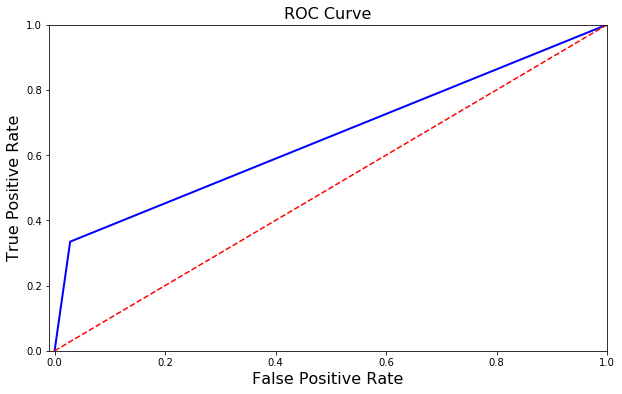

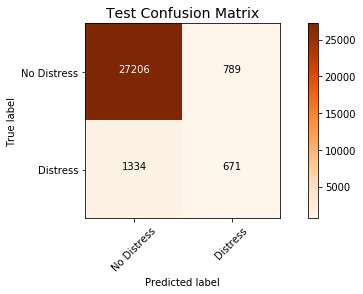

In [33]:
from helper_functions_comprehensive import custom_classification_metrics_function

custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [34]:
from helper_functions_comprehensive import precision_at_recall_threshold_function
predicted_proba = vclf.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, 
                                                             recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.16375336150595468


## <a id=6> Conclusion

Notice how the final performance is similar with the tuned RF from the previous iteration. This implies there is scope for tuning the hyperparams a bit more. The reader is encouraged to tune

## <a id=7> References